<a href="https://colab.research.google.com/github/sneha1012/MultiModal-Genesis/blob/main/cGANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Dependencies**

In [56]:
# Importing necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU, Embedding, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist


In [57]:
!git clone https://github.com/sneha1012/MultiModal-Genesis.git

# Load the dataset
images_np = np.load('MultiModal-Genesis/xray_images.npy')
labels_np = np.load('MultiModal-Genesis/xray_labels.npy')

# Reshape and normalize
images_np = (images_np - 127.5) / 127.5


fatal: destination path 'MultiModal-Genesis' already exists and is not an empty directory.


In [58]:
# Define the self-attention layer (to be integrated into the model)
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

class SelfAttention(Layer):
    def __init__(self, channels, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = channels
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_f')
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_g')
        self.kernel_h = self.add_weight(shape=kernel_shape_h,
                                        initializer='glorot_uniform',
                                        name='kernel_h')
        self.bias_f = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_F')
        self.bias_g = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_g')
        self.bias_h = self.add_weight(shape=(self.filters_h,),
                                      initializer='zeros',
                                      name='bias_h')
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[-1]])

        f = K.conv2d(x,
                     kernel=self.kernel_f,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        f = K.bias_add(f, self.bias_f)
        g = K.conv2d(x,
                     kernel=self.kernel_g,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        g = K.bias_add(g, self.bias_g)
        h = K.conv2d(x,
                     kernel=self.kernel_h,
                     strides=(1, 1), padding='same')  # [bs, h, w, c]
        h = K.bias_add(h, self.bias_h)

        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)  # # [bs, N, N]

        beta = K.softmax(s, axis=-1)  # attention map

        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape


In [59]:
def define_generator(latent_dim, n_classes=7):
    # Label input
    in_label = layers.Input(shape=(1,))
    li = layers.Embedding(n_classes, 50)(in_label)
    n_nodes = 8 * 8 * 64
    li = layers.Dense(n_nodes)(li)
    li = layers.Reshape((8, 8, 64))(li)

    in_lat = layers.Input(shape=(latent_dim,))
    x = layers.Dense(512 * 8 * 8)(in_lat)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((8, 8, 512))(x)

    x = layers.Concatenate()([x, li])

    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)

    x = SelfAttention(128)(x)

    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)

    out = layers.Conv2D(1, (8,8), activation='tanh', padding='same')(x)

    model = Model([in_lat, in_label], out)
    return model


In [60]:
def define_discriminator(in_shape=(128,128,1), n_classes=7):
    in_label = layers.Input(shape=(1,))
    li = layers.Embedding(n_classes, 50)(in_label)
    n_nodes = in_shape[0] * in_shape[1]
    li = layers.Dense(n_nodes)(li)
    li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)

    in_image = layers.Input(shape=in_shape)
    merge = layers.Concatenate()([in_image, li])

    x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Flatten()(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = Model([in_image, in_label], out)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [61]:
def define_gan(generator, discriminator, lr=0.0002, momentum=0.5):
    # Make discriminator non-trainable
    discriminator.trainable = False
    # Inputs
    gen_lat, gen_label = generator.input
    gen_output = generator.output
    # Get discriminator's output
    gan_output = discriminator([gen_output, gen_label])
    # Define the GAN model
    model = Model([gen_lat, gen_label], gan_output)
    # Compile the model
    opt = Adam(learning_rate=lr, beta_1=momentum)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


In [62]:
def load_real_samples(X, labels):
    X = np.expand_dims(X, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return [X, labels]

def generate_real_samples(dataset, n_samples):
    idx = np.random.randint(0, dataset[0].shape[0], n_samples)
    X = dataset[0][idx]
    labels = dataset[1][idx]
    y = np.ones((n_samples, 1))
    return [X, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=7):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    labels = np.random.randint(0, n_classes, n_samples)
    return [x_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples, n_classes=7):
    x_input, labels_input = generate_latent_points(latent_dim, n_samples, n_classes)
    X = generator.predict([x_input, labels_input])
    y = np.zeros((n_samples, 1))
    return [X, labels_input], y


In [63]:
def train_gan(gan, generator, discriminator, dataset, latent_dim, n_epochs=100, batch_size=128):
    # Lists to capture losses
    d_losses_real = []
    d_losses_fake = []
    g_losses = []

    half_batch = batch_size // 2

    for epoch in range(n_epochs):
        for _ in range(dataset[0].shape[0] // batch_size):
            # Real samples with label smoothing
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            y_real = y_real - 0.1 + (0.2 * np.random.random(y_real.shape))

            # Fake samples with label smoothing
            [X_fake, labels], y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            y_fake = 0.1 * np.random.random(y_fake.shape)

            # Update discriminator
            d_loss_real = discriminator.train_on_batch([X_real, labels_real], y_real)
            d_loss_fake = discriminator.train_on_batch([X_fake, labels], y_fake)

            # Prepare points in latent space
            [z_input, labels_input] = generate_latent_points(latent_dim, batch_size)
            # Inverted labels for the fake samples (we try to fool the discriminator here)
            y_gan = np.ones((batch_size, 1))

            # Update the generator via the discriminator's error
            g_loss = gan.train_on_batch([z_input, labels_input], y_gan)

            # Append to the loss lists
            d_losses_real.append(d_loss_real[0])
            d_losses_fake.append(d_loss_fake[0])
            g_losses.append(g_loss)

            print(f"Epoch {epoch + 1}, Batch {_ + 1}, D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss}")

        # Save the generator model at the end of every epoch
        if (epoch + 1) % 10 == 0:
            generator.save('cgan_generator.h5')

    return d_losses_real, d_losses_fake, g_losses


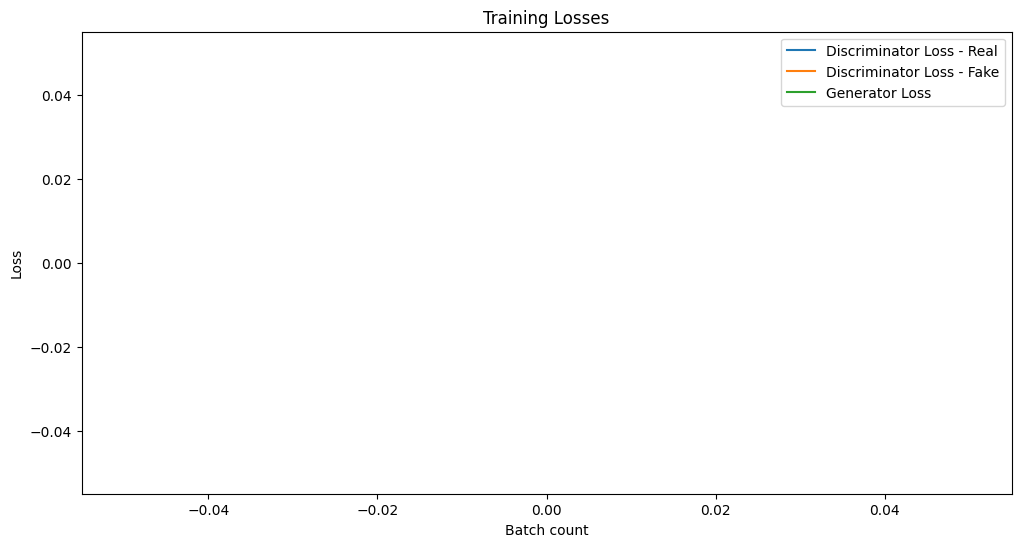

In [64]:
d_losses_real, d_losses_fake, g_losses = train_gan(gan, generator, discriminator, dataset, latent_dim)

# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(d_losses_real, label="Discriminator Loss - Real")
plt.plot(d_losses_fake, label="Discriminator Loss - Fake")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Batch count")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.show()


1/1 [==============================] - 2s 2s/step


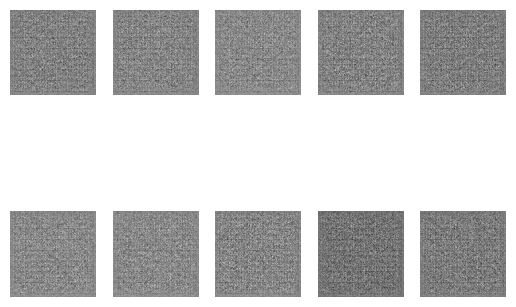

In [65]:
n_samples = 10
[X_fake, _], _ = generate_fake_samples(generator, latent_dim, n_samples)
X_fake = (X_fake + 1) / 2.0

# Plot the generated images
for i in range(n_samples):
    plt.subplot(2, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X_fake[i, :, :, 0], cmap='gray_r')
plt.show()
